In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

In [2]:
# Завантажимо файл і подивимось на вміст
path = r'C:\PythonProject\internet_service_churn.csv'
data = pd.read_csv(path)
data.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [3]:
# Згідно рекомендацій попередьної частини зробим потрібні перетворення по  очищенню данних датасета
data = data.fillna({'reamining_contract':data['reamining_contract'].min()}).dropna()
data = data.iloc[:, 1:]
data.isnull().sum(), data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71893 entries, 0 to 72273
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             71893 non-null  int64  
 1   is_movie_package_subscriber  71893 non-null  int64  
 2   subscription_age             71893 non-null  float64
 3   bill_avg                     71893 non-null  int64  
 4   reamining_contract           71893 non-null  float64
 5   service_failure_count        71893 non-null  int64  
 6   download_avg                 71893 non-null  float64
 7   upload_avg                   71893 non-null  float64
 8   download_over_limit          71893 non-null  int64  
 9   churn                        71893 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 6.0 MB


(is_tv_subscriber               0
 is_movie_package_subscriber    0
 subscription_age               0
 bill_avg                       0
 reamining_contract             0
 service_failure_count          0
 download_avg                   0
 upload_avg                     0
 download_over_limit            0
 churn                          0
 dtype: int64,
 None)

In [4]:
# Розділимо датасет, відберемо ознаки і таргет-колонку
X = data.iloc[:, :-1]
y = data.churn


In [5]:
# Логістична регрессія
# зробимо тренувальну і тестову вибірки даних, подивмось на їх розмірності для контролю.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((57514, 9), (14379, 9), (57514,), (14379,))

In [6]:
# Для логістичної регрессії зробимо конвеер нормалізації данних за допомогою StandardScaler. такы різні по масштабу дані не буде в змозі опрацьовані без помилок
# тренування моделі

pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
pipe.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [7]:
# Напишемо функцію для оцінки якості моделі яка виведе нам дані більш повно і красиво ніж clasification report
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

In [8]:
# Оцінка моделі
log_accuracy, log_precision, log_recall, log_f1, log_roc_auc = evaluate_model(pipe, X_test, y_test)
print("Логистична регресія:")
print(f"Точність: {log_accuracy:.4f}, Повнота: {log_recall:.4f}, F1-міра: {log_f1:.4f}, ROC-AUC: {log_roc_auc:.4f}")

Логистична регресія:
Точність: 0.8750, Повнота: 0.9225, F1-міра: 0.8922, ROC-AUC: 0.8684


In [9]:
# пересвідчимось що classification_report надає нам те саме
y_log_pred = pipe.predict(X_test)
print(classification_report(y_test, y_log_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      6315
           1       0.86      0.92      0.89      8064

    accuracy                           0.87     14379
   macro avg       0.88      0.87      0.87     14379
weighted avg       0.88      0.87      0.87     14379



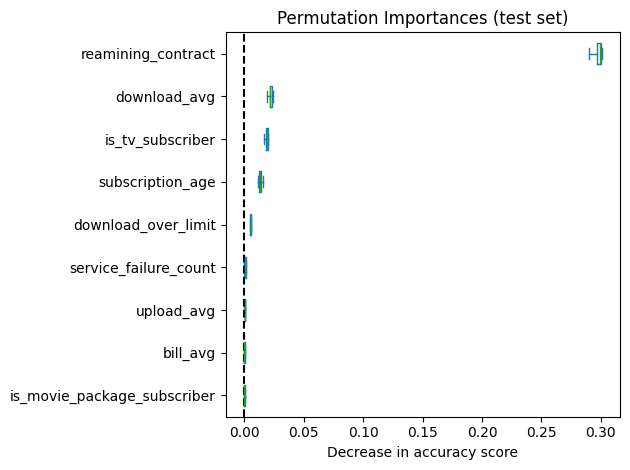

In [10]:
# подивимось якій внесок в результат дає кожна ознака
result = permutation_importance(
    pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
# як можемо бачити біл менш вагомий внесок дають 5 верхніх ознак з графіку, можемо перебудувать модель що збігається з попереднім 
# аналізом в частині EDA, хоча можемо і ні

In [11]:
# тож відкинемо зайві і залишимо 5, оновимо датасет виливші зайве
important_features = ['reamining_contract', 'download_avg', 'is_tv_subscriber','subscription_age', 'download_over_limit']
X_log = X[important_features]
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y, test_size=0.2, random_state=42)
X_log_train.shape, X_log_test.shape, y_log_train.shape, y_log_test.shape


((57514, 5), (14379, 5), (57514,), (14379,))

In [12]:
# Проведемо нормалізацию ознак
scaler = StandardScaler()
X_log_train = scaler.fit_transform(X_log_train)
X_log_test = scaler.fit_transform(X_log_test)

In [13]:
# Виберем найкраші гіперпараметри. Порівняемо ядро за замовчуванням 'lbfgs' та інші, для малих і великих датасетів.
# не всі види регулярізації підтримуються всіма ядрами, але подивимось найкращу комбінацію. cv=10 міркую буде достатньо
param_grid={'solver':['lbfgs', 'sag', 'saga', 'liblinear'], "C":np.logspace(1,3,7), "penalty":['none', 'l1', 'l2', 'elasticnet']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, param_grid, cv=10)
logreg_cv.fit(X_log_train, y_log_train)

C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([  10.        ,   21.5443469 ,   46.41588834,  100.        ,
        215.443469  ,  464.15888336, 1000.        ]),
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'sag', 'saga', 'liblinear']})

In [14]:
# Отже найкращі гіперпараметри такі
print("Найкращі гіперпараметри: ", logreg_cv.best_params_)
print("accuracy :", logreg_cv.best_score_)

Найкращі гіперпараметри:  {'C': 100.0, 'penalty': 'none', 'solver': 'saga'}
accuracy : 0.8699969364945661


In [15]:
# Натренуємо модель зі зменшеними ознаками і обранами параметрами
model_log_5f = LogisticRegression(**logreg_cv.best_params_, random_state=42)
model_log_5f.fit(X_log_train, y_log_train)

C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=100.0, penalty='none', random_state=42, solver='saga')

In [16]:
y_log_5f_pred = model_log_5f.predict(X_log_test)

In [17]:
log_5f_accuracy, log_5f_precision, log_5f_recall, log_5f_f1, log_5f_roc_auc = evaluate_model(model_log_5f, X_log_test, y_log_test)
print("Логистична регресія:")
print(f"Точність: {log_5f_accuracy:.4f}, Повнота: {log_5f_recall:.4f}, F1-міра: {log_5f_f1:.4f}, ROC-AUC: {log_5f_roc_auc:.4f}")
# порівнюючи з попередніми значеннями бачимо що показники погіршилися дуже незначно, в 3-ому знаку після коми.

Логистична регресія:
Точність: 0.8747, Повнота: 0.9199, F1-міра: 0.8917, ROC-AUC: 0.8685


In [18]:
# Ліс випадкових дерев
#порахуємо чи прям всі наші 9 ознак такі вже важливі, для випадку TreeClassifier

tree_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)
tree_model.fit(X_train, y_train)

print("Тренувальна виборка, score:", tree_model.score(X_train, y_train))
print("Тестова виборка, score:", tree_model.score(X_test, y_test))
# та подивимось вагу кожного для нашого моделювання
tree_model.feature_importances_

Тренувальна виборка, score: 0.9400493792815662
Тестова виборка, score: 0.9371305375895403


array([7.59216448e-04, 0.00000000e+00, 1.59422368e-02, 1.16059761e-02,
       9.06485325e-01, 0.00000000e+00, 6.38206060e-02, 1.07205952e-04,
       1.27943402e-03])

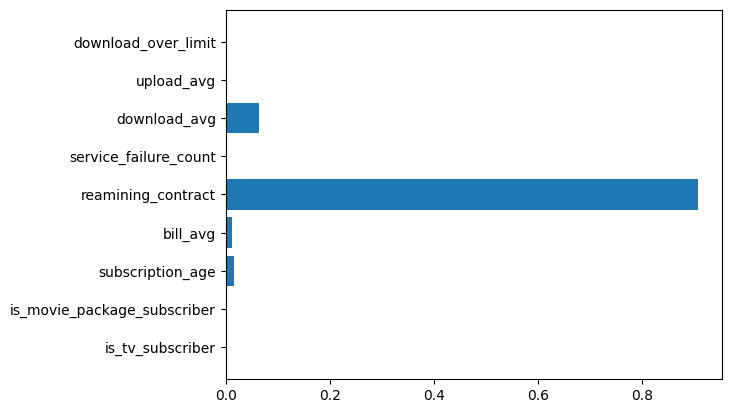

In [19]:
# візуалізуемо то наочно, і як бачимо з цифр і гістограми якусь зриму вагу мають лише 4
plt.barh(range(len(tree_model.feature_importances_)), tree_model.feature_importances_)
plt.yticks(range(len(X.columns)), X.columns)
plt.show()

In [20]:
# тож відкинемо зайві і залишимо 4, хоча можливо достатньо і двух, а леж ми хочемо найточніше. 
# оновимо датасет виливші зайве
important_features = ['download_avg', 'reamining_contract', 'bill_avg', 'subscription_age']
X_tree = X[important_features]
X_tree.head()

,download_avg,reamining_contract,bill_avg,subscription_age
0,8.4,0.14,25,11.95
1,0.0,0.00,0,8.22
2,13.7,0.00,16,8.91
3,0.0,0.00,21,6.87
4,0.0,0.00,0,6.39


In [21]:
# визначимо тренувальну і тестову вибірку з оновленого датасету, 
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)
# Проведемо нормалізацию ознак
scaler = StandardScaler()
X_tree_train = scaler.fit_transform(X_tree_train)
X_tree_test = scaler.fit_transform(X_tree_test)

In [22]:
# визначимо які гіперпарметрі є найкращими для нашого датасету, бо попередній розрахунок міг буть і не оптимальним. тут зменшим параметр cv.

ranforest = RandomForestClassifier()

# визначення сітки гіперпараметрів для перебору
param_grid_tree = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 4]
}
# створення об'єкта GridSearchCV
ranforest_cv = GridSearchCV(estimator=ranforest, param_grid=param_grid_tree, cv=5, scoring='accuracy')

# запуск пошуку найкращих гіперпараметрів
ranforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [23]:
# Отже найкращі гіперпараметри такі
print("Найкращі гіперпараметри: ", ranforest_cv.best_params_)
print("accuracy :", ranforest_cv.best_score_)

Найкращі гіперпараметри:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
accuracy : 0.9420314641861666


In [24]:
# створення Random Forest класифікатора
model_tree = RandomForestClassifier(**ranforest_cv.best_params_, random_state=42)
# навчання моделі
model_tree.fit(X_tree_train, y_tree_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [25]:
# прогнозування на тестових даних
y_tree_pred = model_tree.predict(X_tree_test)
print("Тренувальна виборка, score:", model_tree.score(X_tree_train, y_tree_train))
print("Тестова виборка, score:", model_tree.score(X_tree_test, y_tree_test))


Тренувальна виборка, score: 0.999930451716104
Тестова виборка, score: 0.9327491480631477


In [26]:
model_tree_accuracy, model_tree_precision, model_tree_recall, model_tree_f1, model_tree_roc_auc = evaluate_model(model_tree, X_tree_test, y_tree_test)
print("Ліс випадкових дерев:")
print(f"Точність: {model_tree_accuracy:.4f}, Повнота: {model_tree_precision:.4f}, F1-міра: {model_tree_f1:.4f}, ROC-AUC: {model_tree_roc_auc:.4f}")

# пересвідчимось що classification_report надає нам те саме
print(classification_report(y_tree_test, y_tree_pred))

Ліс випадкових дерев:
Точність: 0.9327, Повнота: 0.9405, F1-міра: 0.9400, ROC-AUC: 0.9318
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6315
           1       0.94      0.94      0.94      8064

    accuracy                           0.93     14379
   macro avg       0.93      0.93      0.93     14379
weighted avg       0.93      0.93      0.93     14379



In [ ]:
# візуалізація дерева якшо встановлен модуль graphviz (на цій машині не встановлен корректно, а там де встановлен обчислювальна потужність слабка)
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    model_tree.estimators_[0], out_file=None, feature_names=X_tree.columns,
    class_names=X_tree.columns,
    filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("Відтік")
graph

In [ ]:
# Спробуємо також Стохастичний Градієнтний спуск у варіанті класифікатора.

In [29]:
# визначимо які гіперпарметрі є найкращими для нашого датасету, бо попередній розрахунок міг буть і не оптимальним. тут зменшим параметр cv.
# викорастаемо вибірку ознак обраної для логістичної регрессії. для цього классифікатора розглянемо декілька функцій втрат.
model_sgd = SGDClassifier(max_iter=1000)
param_grid_sgd = {
    'loss' : ['hinge', 'log_loss', 'squared_hinge', 'modified_huber'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'penalty' : ['l1', 'elasticnet', 'l2', None],
}

# створення об'єкта GridSearchCV
sgd_cv = GridSearchCV(model_sgd, param_grid=param_grid_sgd, cv=5, scoring='accuracy')

# запуск пошуку найкращих гіперпараметрів
sgd_cv.fit(X_log_train, y_log_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log_loss', 'squared_hinge',
                                  'modified_huber'],
                         'penalty': ['l1', 'elasticnet', 'l2', None]},
             scoring='accuracy')

In [30]:
# Отже найкращі гіперпараметри такі
print("Найкращі гіперпараметри: ", sgd_cv.best_params_)
print("accuracy :", sgd_cv.best_score_)

Найкращі гіперпараметри:  {'alpha': 0.1, 'loss': 'hinge', 'penalty': None}
accuracy : 0.8723789200591536


In [31]:
# створення об'єкта SGDClassifier з найкращими
model_sgd = SGDClassifier(**sgd_cv.best_params_, random_state=42)
# навчання моделі
model_sgd.fit(X_log_train, y_log_train)


SGDClassifier(alpha=0.1, penalty=None, random_state=42)

In [32]:
# прогнозування на тестових даних
y_sgd_pred = model_sgd.predict(X_log_test)
print("Тренувальна виборка, score:", model_sgd.score(X_log_train, y_log_train))
print("Тестова виборка, score:", model_sgd.score(X_log_test, y_log_test))


Тренувальна виборка, score: 0.8677713252425496
Тестова виборка, score: 0.8723833368106266


In [33]:
model_sgd_accuracy, model_sgd_precision, model_sgd_recall, model_sgd_f1, model_sgd_roc_auc = evaluate_model(model_sgd, X_log_test, y_log_test)
print("Градієнтний бустінг:")
print(f"Точність: {model_sgd_accuracy:.4f}, Повнота: {model_sgd_precision:.4f}, F1-міра: {model_sgd_f1:.4f}, ROC-AUC: {model_sgd_roc_auc:.4f}")

# пересвідчимось що classification_report надає нам те саме
print(classification_report(y_log_test, y_sgd_pred))

Градієнтний бустінг:
Точність: 0.8724, Повнота: 0.8564, F1-міра: 0.8908, ROC-AUC: 0.8647
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      6315
           1       0.86      0.93      0.89      8064

    accuracy                           0.87     14379
   macro avg       0.88      0.86      0.87     14379
weighted avg       0.87      0.87      0.87     14379



In [35]:
# Задля прикінцевій классифікації побудуемо ансамбль з попередньонавчених моделей
# В різні класифікатори в нас приходять трохі різні ознаки, тож побудуемо обьект який іх буде видокремлювать з вхідних даних.
# вбудуємо його потім в пайплайн обробки
from sklearn.base import BaseEstimator, TransformerMixin

class PreprocessChurnData(BaseEstimator, TransformerMixin):
    def __init__(self, important_features=None):
        self.important_features = important_features

    def set(self, important_features):
        self.important_features = important_features

    def fit(self, X, y=None):
       return self

    def transform(self, X, y=None):
        return X[self.important_features]

In [36]:
important_features_log = ['reamining_contract', 'download_avg', 'is_tv_subscriber','subscription_age', 'download_over_limit']
important_features_trees = ['download_avg', 'reamining_contract', 'bill_avg', 'subscription_age']

In [37]:
from sklearn.ensemble import StackingClassifier

In [43]:
estimators = [
    ('trees',  make_pipeline(PreprocessChurnData(important_features_trees), StandardScaler(), RandomForestClassifier(**ranforest_cv.best_params_, random_state=42))),
    ('logreg', make_pipeline(PreprocessChurnData(important_features_log), StandardScaler(), LogisticRegression(**logreg_cv.best_params_, random_state=42))),
    ('sgd',   make_pipeline(PreprocessChurnData(important_features_log), StandardScaler(), SGDClassifier(**sgd_cv.best_params_, random_state=42)))
     ]
final_model_ml = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
final_model_ml.fit(X_train, y_train)


C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the

StackingClassifier(estimators=[('trees',
                                Pipeline(steps=[('preprocesschurndata',
                                                 PreprocessChurnData(important_features=['download_avg',
                                                                                         'reamining_contract',
                                                                                         'bill_avg',
                                                                                         'subscription_age'])),
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(n_estimators=200,
                                                                        random_state=42))])),
                               ('logreg',
                                Pipeline(steps=[('preprocessc...
                                                                    solver='saga'))])),
                               ('sgd',
                                Pipeline(steps=[('preprocesschurndata',
                                                 PreprocessChurnData(important_features=['reamining_contract',
                                                                                         'download_avg',
                                                                                         'is_tv_subscriber',
                                                                                         'subscription_age',
                                                                                         'download_over_limit'])),
                                                ('standardscaler',
                                                 StandardScaler()),
                                                ('sgdclassifier',
                                                 SGDClassifier(alpha=0.1,
                                                               penalty=None,
                                                               random_state=42))]))],
                   final_estimator=LogisticRegression())

In [44]:
# прогнозування на тестових даних
y_final_ml_pred = final_model_ml.predict(X_test)
print("Тренувальна виборка, score:", final_model_ml.score(X_train, y_train))
print("Тестова виборка, score:", final_model_ml.score(X_test, y_test))


Тренувальна виборка, score: 0.9998261292902597
Тестова виборка, score: 0.9402601015369636


In [46]:
y_final_prob = final_model_ml.predict_proba(X_test)[:, 1]
y_final_prob

array([0.03249306, 0.04168596, 0.97784477, ..., 0.96833898, 0.97838765,
       0.78887926])

In [47]:
model_final_accuracy, model_final_precision, model_final_recall, model_final_f1, model_final_roc_auc = evaluate_model(final_model_ml, X_test, y_test)
print("Стекінг:")
print(f"Точність: {model_final_accuracy:.4f}, Повнота: {model_final_precision:.4f}, F1-міра: {model_final_f1:.4f}, ROC-AUC: {model_final_roc_auc:.4f}")

# пересвідчимось що classification_report надає нам те саме
print(classification_report(y_test, y_final_ml_pred))

Стекінг:
Точність: 0.9403, Повнота: 0.9525, F1-міра: 0.9464, ROC-AUC: 0.9402
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6315
           1       0.95      0.94      0.95      8064

    accuracy                           0.94     14379
   macro avg       0.94      0.94      0.94     14379
weighted avg       0.94      0.94      0.94     14379



In [48]:
# Використовуючи Стекінг ми змогли покращити показники ще на 1% від найкращих отриманих методом Випадкового лісу
# збережемо модель для подальшого використання
joblib.dump(final_model_ml, r'C:\PythonProject\model_final_ml.pkl')

['C:\\PythonProject\\model_final_ml.pkl']

In [55]:
# зробимо конвеєри для попередьної обробки даних з датасету, їх нормалізації і поеднаємо їх з нашими моделями окремих класифікаторів
pipe_rf = make_pipeline(PreprocessChurnData(important_features_trees), 
                        StandardScaler(), 
                        RandomForestClassifier(**ranforest_cv.best_params_, random_state=42))
pipe_rf.fit(X_train, y_train)    

Pipeline(steps=[('preprocesschurndata',
                 PreprocessChurnData(important_features=['download_avg',
                                                         'reamining_contract',
                                                         'bill_avg',
                                                         'subscription_age'])),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [56]:
# Збережемо модель для подальшо використання
joblib.dump(pipe_rf, r'C:\PythonProject\model_tree.pkl')

['C:\\PythonProject\\model_tree.pkl']

In [57]:
pipe_lg = make_pipeline(PreprocessChurnData(important_features_log), StandardScaler(), LogisticRegression(**logreg_cv.best_params_, random_state=42))
pipe_lg.fit(X_train, y_train)   

C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\asgar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Pipeline(steps=[('preprocesschurndata',
                 PreprocessChurnData(important_features=['reamining_contract',
                                                         'download_avg',
                                                         'is_tv_subscriber',
                                                         'subscription_age',
                                                         'download_over_limit'])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100.0, penalty='none', random_state=42,
                                    solver='saga'))])

In [58]:
# Збережемо модель для подальшо використання
joblib.dump(pipe_lg, r'C:\PythonProject\model_log.pkl')

['C:\\PythonProject\\model_log.pkl']

In [59]:
pipe_sgd = make_pipeline(PreprocessChurnData(important_features_log), StandardScaler(), SGDClassifier(**sgd_cv.best_params_, random_state=42))
pipe_sgd.fit(X_train, y_train) 

Pipeline(steps=[('preprocesschurndata',
                 PreprocessChurnData(important_features=['reamining_contract',
                                                         'download_avg',
                                                         'is_tv_subscriber',
                                                         'subscription_age',
                                                         'download_over_limit'])),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.1, penalty=None, random_state=42))])

In [60]:
# Збережемо модель для подальшо використання
joblib.dump(model_sgd, r'C:\PythonProject\model_sgd.pkl')

['C:\\PythonProject\\model_sgd.pkl']